#getting ready

In [1]:
#!python3 --version

In [2]:
#!pip uninstall -y tensorflow keras keras-nightly keras-preprocessing keras-core numpy pandas
#!pip install tensorflow==2.15 numpy==1.25.2 pandas==1.5.3


In [3]:
#from google.colab import drive
import pandas as pd
import numpy as np
import librosa
import librosa.display
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Concatenate, GRU, TimeDistributed
import concurrent.futures
import time
from tensorflow.keras.metrics import AUC
import h5py
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d


#code

##working with the data

In [4]:
#drive.mount('/content/drive', force_remount=True)

In [5]:
meta_data = pd.read_csv('audio_metadata - filtered.csv', sep=',')

In [6]:
meta_data.drop(columns=['group', 'category', 'sub_category'], inplace=True)

In [7]:
#meta_data = meta_data[meta_data['Reverse'] == 0].copy()

In [8]:
meta_data

,id,file_path,file_name,Reverse,Forward,One_Shot,Loop,Drum,Percussion,Effect,...,Timpani,Congo,Vocal FX,Triangle,China,Cowbell,Bell,Orchestra,Metalic Tap,Vibraslap
0,3843,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3443,808 samples/808/bass (12).wav,bass (12).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3440,808 samples/808/bass (13).wav,bass (13).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3439,808 samples/808/bass (14).wav,bass (14).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3454,808 samples/808/bass (16).wav,bass (16).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,4373,we unite - ultimate future bounce (sample pack...,14 Clap.wav,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2043,4361,we unite - ultimate future bounce (sample pack...,17 Clap.wav,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2044,4376,we unite - ultimate future bounce (sample pack...,18 Clap.wav,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2045,4375,we unite - ultimate future bounce (sample pack...,19 Clap.wav,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
col_names = meta_data.columns
print(col_names)

cols_to_keep = ['id', 'Reverse', 'Forward', 'Drum' , 'Percussion', 'Kick', 'Hi Hat', 'Clap']

Index(['id', 'file_path', 'file_name', 'Reverse', 'Forward', 'One_Shot',
       'Loop', 'Drum', 'Percussion', 'Effect', 'Vocal', 'Instrument', 'Kick',
       '808', 'Clap', 'Ride', 'Hi Hat', 'Tom', 'Snare', 'Impact', 'Noise',
       'Hit', 'Sweep', 'Misc', 'Rim Shot', 'Clave', 'Tambourine', 'Crash',
       'Ambient', 'Stab', 'Other', 'Chord', 'Glitch', 'Shaker', 'Snap',
       'Timpani', 'Congo', 'Vocal FX', 'Triangle', 'China', 'Cowbell', 'Bell',
       'Orchestra', 'Metalic Tap', 'Vibraslap'],
      dtype='object')


In [10]:
df_id = np.array(meta_data['id'].astype(int)).flatten()

wavs = []
srs = []

def load_sample(f, sample_id):
    group = f["audio_data"][str(sample_id)]
    waveform = np.array(group["waveform"])
    sample_rate = np.array(group["sample_rate"])
    return waveform, sample_rate

with h5py.File('filtered_audio_data.h5', "r") as f:
    for i in df_id:
        waveform, sr = load_sample(f, i)  # load sample with id=42
        wavs.append(waveform)
        srs.append(sr)

In [11]:
samples = pd.DataFrame({'id': df_id, 'waveform': wavs, 'sample_rate': srs})
samples['beginning_time'] = samples.apply(lambda row: len(row['waveform']) / row['sample_rate'], axis=1)

In [12]:
def highpass_filter(y, sr, cutoff=10.0, order=2):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, y)

def lowpass_filter(y, sr, cutoff=150.0, order=2):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, y)

def bandpass_filter(y, sr, lowcut=10.0, highcut=150.0, order=2):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return filtfilt(b, a, y)

def preprocess_audio(y, sr, top_db=120):
    y = librosa.resample(y, orig_sr=sr, target_sr=44100)
    y = highpass_filter(y, sr)
    y_rev = y[::-1]
    y_trimmed, _ = librosa.effects.trim(y_rev, top_db=top_db)
    y_reversed_back = y_trimmed[::-1]
    return y_reversed_back

In [13]:
# completely good to go
epsilon = 1e-8  # Small value to avoid division by zero

def get_top_middle_bottom_energies(waveform, sample_rate, n_fft=2048, hop_length=256, threshold=0.45):
  stft = np.abs(librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length))
  frequencies = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
  st = stft / (stft.max() + epsilon)

  peaks = st.max(axis=0)
  peak_bin_indices = np.argmax(st, axis=0)
  centroid_by_vol = frequencies[peak_bin_indices]
  upper_band = []
  lower_band = []

  for frame_idx, peak_bin in enumerate(peak_bin_indices):
    spectrum = st[:, frame_idx]
    upper_sub_spectrum = spectrum[peak_bin+1:]
    lower_sub_spectrum = spectrum[:peak_bin]

    th = peaks[frame_idx] * threshold

    above_thresh_upper = np.where(upper_sub_spectrum > th)[0]
    above_thresh_lower = np.where(lower_sub_spectrum > th)[0]

    if len(above_thresh_upper) > 0:
      max_bin = peak_bin + 1 + above_thresh_upper[-1]
      upper_band.append(frequencies[max_bin])
    else:
      upper_band.append(frequencies[peak_bin])

    if len(above_thresh_lower) > 0:
      if above_thresh_lower[0] == 0:
        if len(above_thresh_lower) > 1:
          min_bin = above_thresh_lower[1]
        else:
          min_bin = peak_bin
      else:
        min_bin = above_thresh_lower[0]
      lower_band.append(frequencies[min_bin])
    else:
      lower_band.append(frequencies[peak_bin])

  upper_band = np.array(upper_band)
  lower_band = np.array(lower_band)

  sigma = 1.5  # Controls the width of the smoothing — adjust as needed
  upper_band = gaussian_filter1d(upper_band, sigma=sigma)
  centroid_by_vol = gaussian_filter1d(centroid_by_vol, sigma=sigma)
  lower_band = gaussian_filter1d(lower_band, sigma=sigma)

  upper_band = np.floor(upper_band).astype(np.uint16)
  centroid_by_vol = np.floor(centroid_by_vol).astype(np.uint16)
  lower_band = np.floor(lower_band).astype(np.uint16)

  return np.stack([upper_band, centroid_by_vol, lower_band], axis=0)

In [14]:
# resample the samples
# samples['waveform'] = samples.apply(lambda row: librosa.resample(row['waveform'], orig_sr=row['sample_rate'], target_sr=44100), axis=1)
samples['waveform'] = samples.apply(lambda row: preprocess_audio(row['waveform'], row['sample_rate']), axis=1)
samples['sample_rate'] = 44100

In [15]:
"""samples['waveform_150_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate']), axis=1)
samples['waveform_500_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=500), axis=1)
samples['waveform_2k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=2000), axis=1)
samples['waveform_6k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=6000), axis=1)
samples['waveform_10k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=10000), axis=1)

samples['waveform_150_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=150), axis=1)
samples['waveform_500_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=500), axis=1)
samples['waveform_2k_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=2000), axis=1)
samples['waveform_6k_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=6000), axis=1)
samples['waveform_10k_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=10000), axis=1)"""

"samples['waveform_150_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate']), axis=1)\nsamples['waveform_500_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=500), axis=1)\nsamples['waveform_2k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=2000), axis=1)\nsamples['waveform_6k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=6000), axis=1)\nsamples['waveform_10k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=10000), axis=1)\n\nsamples['waveform_150_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=150), axis=1)\nsamples['waveform_500_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=500), axis=1)\nsamples['waveform_2k_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sa

In [16]:
df = pd.merge(meta_data, samples, on='id')

In [17]:
len(df)

2047

In [18]:
# reverses one shot samples that are marked as forward
new_rows = []
max_id = df['id'].max()
print(max_id)

for i, (waveform, reverse, forward, oneshot) in enumerate(zip(df['waveform'], df['Reverse'], df['Forward'], df['One_Shot'])):
    if reverse == 0 and forward == 1 and oneshot == 1:
        audio = waveform[::-1]
        #id = df['id'].max() + 1
        row = df.iloc[i].copy()
        row['file_path'] = str(row['file_path']).split('.')[0] + '_rev.' + '.'.join(str(row['file_path']).split('.')[1:])
        row['file_name'] = str(row['file_name']).split('.')[0] + '_rev.' + '.'.join(str(row['file_name']).split('.')[1:])
        row['id'] += max_id
        row['waveform'] = audio
        row['Reverse'] = 1
        row['Forward'] = 0
        new_rows.append(row)

if new_rows:
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

18332


In [19]:
df["time"] = df.apply(lambda row: len(row['waveform']) / row['sample_rate'], axis=1)
df['is_long'] = df['time'] > 5

In [20]:
for i, (waveform, sr, is_long) in enumerate(zip(df['waveform'], df['sample_rate'], df['is_long'])):
    if len(waveform) <= int(sr / 2):
        pad_len = int(sr / 2) - len(waveform)
        waveform = np.pad(waveform, (0, pad_len), mode='constant')
    else:
        remainder = len(waveform) % int(sr / 2)
        remainder = int(sr / 2) - remainder
        # full_size = len(waveform) + remainder
        waveform = np.pad(waveform, (0, remainder), mode='constant')

    '''if is_long == True:
        fade_len = int(sr * 0.1
    elif is_long == False:
        fade_len = int(sr * 0.1)
        waveform = waveform[:sr]
        fade = np.linspace(1, 0, fade_len)
        waveform[-fade_len:] *= fade'''

    df.at[i, 'waveform'] = waveform

In [21]:
# df["time"] = df.apply(lambda row: len(row['waveform']) / row['sample_rate'], axis=1)

In [22]:
df

,id,file_path,file_name,Reverse,Forward,One_Shot,Loop,Drum,Percussion,Effect,...,Cowbell,Bell,Orchestra,Metalic Tap,Vibraslap,waveform,sample_rate,beginning_time,time,is_long
0,3843,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1,0,1,0,0,...,0,0,0,0,0,"[-0.006019970409507629, -0.006184377832092783,...",44100,0.466122,0.466122,False
1,3443,808 samples/808/bass (12).wav,bass (12).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,"[-0.11037421530703469, -0.11149434109602765, -...",44100,0.251519,0.251519,False
2,3440,808 samples/808/bass (13).wav,bass (13).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,"[-0.15586456448634184, -0.1574027766114431, -0...",44100,0.101361,0.101361,False
3,3439,808 samples/808/bass (14).wav,bass (14).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,"[-0.15896714769523557, -0.15887888934624483, -...",44100,0.182540,0.182540,False
4,3454,808 samples/808/bass (16).wav,bass (16).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,"[-0.3009931289487842, -0.30866833521435133, -0...",44100,0.069841,0.069841,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,22705,we unite - ultimate future bounce (sample pack...,14 Clap_rev.wav,1,0,1,0,0,1,0,...,0,0,0,0,0,"[-1.395408006953748e-09, -1.5496946569450588e-...",44100,0.468730,0.468730,False
4009,22693,we unite - ultimate future bounce (sample pack...,17 Clap_rev.wav,1,0,1,0,0,1,0,...,0,0,0,0,0,"[-1.322737579356968e-09, -1.4689696710976562e-...",44100,0.468730,0.468730,False
4010,22708,we unite - ultimate future bounce (sample pack...,18 Clap_rev.wav,1,0,1,0,0,1,0,...,0,0,0,0,0,"[-1.4615227638750908e-09, -1.623105043701656e-...",44100,0.468730,0.468730,False
4011,22707,we unite - ultimate future bounce (sample pack...,19 Clap_rev.wav,1,0,1,0,0,1,0,...,0,0,0,0,0,"[-9.433946186319863e-10, -1.0477868374567746e-...",44100,0.468730,0.468730,False


In [23]:
def extract_mfcc(audio, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc

def extract_mel(audio, sr, n_mels=64):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_db

def resize_and_normalize(current_features, all_features, target_shape=(64, 64)):
    current_features = np.array(current_features)
    current_features = tf.image.resize(current_features[..., np.newaxis], target_shape)

    all_features = np.array(all_features)
    #all_features = tf.image.resize(all_features[..., np.newaxis], target_shape)

    epsilon = 1e-8  # Small value to avoid division by zero
    feature = current_features / (tf.reduce_max(all_features) + epsilon)
    return feature.numpy()  # shape: (64, 64, 1)

In [24]:
def extract_centroid(audio, sr):
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    return centroid

def extract_bandwidth(audio, sr):
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    return bandwidth

In [25]:
cut_df = df[df['is_long'] == False].copy()

In [26]:
len(cut_df)

3911

In [27]:
# test_labels = 'id,Reverse,Forward,Drum,Percussion,One_Shot,Loop'.split(',')
impt_labels = 'id,file_path,file_name,Reverse,Forward,One_Shot,Loop,Drum,Percussion,Kick,Hi Hat,Clap'.split(',')
impt_labels

['id',
 'file_path',
 'file_name',
 'Reverse',
 'Forward',
 'One_Shot',
 'Loop',
 'Drum',
 'Percussion',
 'Kick',
 'Hi Hat',
 'Clap']

In [28]:
cut = cut_df[impt_labels].copy()
len(cut)

3911

In [29]:
cut.head(5)

,id,file_path,file_name,Reverse,Forward,One_Shot,Loop,Drum,Percussion,Kick,Hi Hat,Clap
0,3843,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1,0,1,0,1,0,0
1,3443,808 samples/808/bass (12).wav,bass (12).wav,0,1,1,0,1,0,1,0,0
2,3440,808 samples/808/bass (13).wav,bass (13).wav,0,1,1,0,1,0,1,0,0
3,3439,808 samples/808/bass (14).wav,bass (14).wav,0,1,1,0,1,0,1,0,0
4,3454,808 samples/808/bass (16).wav,bass (16).wav,0,1,1,0,1,0,1,0,0


In [30]:
# columns_to_check = ['Kick', '808', 'Clap', 'Hi Hat', 'Snare']
#columns_to_check = ['Kick', 'Hi Hat', 'Clap']

# Filter rows where there is a 1 in any of the specified columns
#filtered_cut_df = cut_df[columns_to_check].copy()
#filtered_cut_df['id'] = cut_df['id'].astype(int)
#len(filtered_cut_df)

In [31]:
#columns_to_check += ['id']

In [32]:
#len(filtered_cut_df)

In [33]:
#filtered_cut_df = filtered_cut_df[columns_to_check].copy()
cut_df[['waveform', 'sample_rate', 'beginning_time', 'is_long']]

,waveform,sample_rate,beginning_time,is_long
0,"[-0.006019970409507629, -0.006184377832092783,...",44100,0.466122,False
1,"[-0.11037421530703469, -0.11149434109602765, -...",44100,0.251519,False
2,"[-0.15586456448634184, -0.1574027766114431, -0...",44100,0.101361,False
3,"[-0.15896714769523557, -0.15887888934624483, -...",44100,0.182540,False
4,"[-0.3009931289487842, -0.30866833521435133, -0...",44100,0.069841,False
...,...,...,...,...
4008,"[-1.395408006953748e-09, -1.5496946569450588e-...",44100,0.468730,False
4009,"[-1.322737579356968e-09, -1.4689696710976562e-...",44100,0.468730,False
4010,"[-1.4615227638750908e-09, -1.623105043701656e-...",44100,0.468730,False
4011,"[-9.433946186319863e-10, -1.0477868374567746e-...",44100,0.468730,False


In [34]:
#cut = pd.merge(cut, filtered_cut_df, on='id')
cut = pd.merge(cut, cut_df[['id', 'waveform', 'sample_rate', 'beginning_time', 'is_long']], on='id')

In [35]:
cut

,id,file_path,file_name,Reverse,Forward,One_Shot,Loop,Drum,Percussion,Kick,Hi Hat,Clap,waveform,sample_rate,beginning_time,is_long
0,3843,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1,0,1,0,1,0,0,"[-0.006019970409507629, -0.006184377832092783,...",44100,0.466122,False
1,3443,808 samples/808/bass (12).wav,bass (12).wav,0,1,1,0,1,0,1,0,0,"[-0.11037421530703469, -0.11149434109602765, -...",44100,0.251519,False
2,3440,808 samples/808/bass (13).wav,bass (13).wav,0,1,1,0,1,0,1,0,0,"[-0.15586456448634184, -0.1574027766114431, -0...",44100,0.101361,False
3,3439,808 samples/808/bass (14).wav,bass (14).wav,0,1,1,0,1,0,1,0,0,"[-0.15896714769523557, -0.15887888934624483, -...",44100,0.182540,False
4,3454,808 samples/808/bass (16).wav,bass (16).wav,0,1,1,0,1,0,1,0,0,"[-0.3009931289487842, -0.30866833521435133, -0...",44100,0.069841,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,22705,we unite - ultimate future bounce (sample pack...,14 Clap_rev.wav,1,0,1,0,0,1,0,0,1,"[-1.395408006953748e-09, -1.5496946569450588e-...",44100,0.468730,False
3907,22693,we unite - ultimate future bounce (sample pack...,17 Clap_rev.wav,1,0,1,0,0,1,0,0,1,"[-1.322737579356968e-09, -1.4689696710976562e-...",44100,0.468730,False
3908,22708,we unite - ultimate future bounce (sample pack...,18 Clap_rev.wav,1,0,1,0,0,1,0,0,1,"[-1.4615227638750908e-09, -1.623105043701656e-...",44100,0.468730,False
3909,22707,we unite - ultimate future bounce (sample pack...,19 Clap_rev.wav,1,0,1,0,0,1,0,0,1,"[-9.433946186319863e-10, -1.0477868374567746e-...",44100,0.468730,False


In [251]:
# took 7 minutes to run. parallelize this

mfcc_processed = []
mel_processed = []
#
bandwidth_arr_window = []
onset_str_arr_window = []
zcr_arr_window = []
centroid_arr_window = []
energies_arr_window = []
rms_arr_window = []

energies_arr = []
onset_str_arr = []
zcr_arr = []
centroid_arr = []
bandwidth_arr = []
onset_frame_len_arr = []

window_size = 0.5
hop_size = 0.25

i = 0
for audio, sr in zip(cut_df["waveform"], cut_df["sample_rate"]):
    if i % 50 == 0:
      print(i)
    i += 1
    window_samples = int(window_size * sr)
    hop_samples = int(hop_size * sr)
    mfcc_windows = []
    mel_windows = []

    #
    onset_windows = []
    zcr_windows = []
    centroid_windows = []
    bandwidth_windows = []
    energies_windows = []
    rms_windows = []

    fade_len = int(sr * 0.025)
    fade_out = np.linspace(1, 0, fade_len)
    fade_in = np.linspace(0, 1, fade_len)

    # Extract features
    for start in range(0, len(audio) - window_samples + 1, hop_samples):
        window_audio = audio[start:start + window_samples].copy()

        # fade out
        window_audio[-fade_len:] *= fade_out

        #fade in if not at the beginning
        if start != 0:
          window_audio[:fade_len] *= fade_in

        mfcc = extract_mfcc(window_audio, sr)
        mel = extract_mel(window_audio, sr)

        #
        onset_str_w = librosa.onset.onset_strength(y=window_audio, sr=sr)
        zcr_w = librosa.feature.zero_crossing_rate(window_audio)
        centroid_w = extract_centroid(window_audio, sr)
        bandwidth_w = extract_bandwidth(window_audio, sr)
        energies_w = get_top_middle_bottom_energies(window_audio, sr)
        rms_w = librosa.feature.rms(y=window_audio)

        # Resize + normalize
        mfcc_resized = resize_and_normalize(mfcc.astype(np.float32), audio.astype(np.float32))
        mel_resized = resize_and_normalize(mel.astype(np.float32), audio.astype(np.float32))

        mfcc_windows.append(mfcc_resized)
        mel_windows.append(mel_resized)

        #
        onset_windows.append(onset_str_w)
        zcr_windows.append(zcr_w)
        centroid_windows.append(centroid_w)
        bandwidth_windows.append(bandwidth_w)
        energies_windows.append(energies_w)
        rms_windows.append(rms_w)

        del window_audio

    mfcc_windows = np.stack(mfcc_windows, axis=0)
    mel_windows = np.stack(mel_windows, axis=0)

    #
    onset_windows = np.stack(onset_windows, axis=0)
    zcr_windows = np.stack(zcr_windows, axis=0)
    centroid_windows = np.stack(centroid_windows, axis=0)
    bandwidth_windows = np.stack(bandwidth_windows, axis=0)
    energies_windows = np.stack(energies_windows, axis=0)
    rms_windows = np.stack(rms_windows, axis=0)

    onset_str = librosa.onset.onset_strength(y=audio, sr=sr, hop_length=512, lag=3, max_size=5, aggregate=np.mean)
    onset_str = gaussian_filter1d(onset_str, sigma=2)
    onset_frame_len = len(librosa.onset.onset_detect(onset_envelope=onset_str, sr=sr, hop_length=512, backtrack=False, pre_max=10, post_max=10, pre_avg=20, post_avg=20, delta=0.1, wait=50))
    zcr = librosa.feature.zero_crossing_rate(audio)
    energies = get_top_middle_bottom_energies(audio, sr)
    centroid = extract_centroid(audio, sr)
    bandwidth = extract_bandwidth(audio, sr)

    # Append to lists
    mfcc_processed.append(mfcc_windows)
    mel_processed.append(mel_windows)

    #
    centroid_arr_window.append(centroid_windows)
    bandwidth_arr_window.append(bandwidth_windows)
    onset_str_arr_window.append(onset_windows)
    zcr_arr_window.append(zcr_windows)
    energies_arr_window.append(energies_windows)
    rms_arr_window.append(rms_windows)

    onset_str_arr.append(onset_str)
    zcr_arr.append(zcr)
    centroid_arr.append(centroid)
    bandwidth_arr.append(bandwidth)
    energies_arr.append(energies)
    onset_frame_len_arr.append(onset_frame_len)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900


In [252]:
# Store back in DataFrame
cut['mfcc_resized'] = mfcc_processed
cut['mel_resized'] = mel_processed

cut['centroid_window'] = centroid_arr_window
cut['bandwidth_window'] = bandwidth_arr_window
cut['onset_strength_window'] = onset_str_arr_window
cut['zcr_window'] = zcr_arr_window
cut['energies_window'] = energies_arr_window
cut['rms_window'] = rms_arr_window

cut['energies'] = energies_arr
#cut_df['centroid'] = cut_df['energies'].apply(lambda x: x[1])
cut['centroid'] = centroid_arr
cut['bandwidth'] = bandwidth_arr
cut['onset_strength'] = onset_str_arr
cut['onset_frame_count'] = onset_frame_len_arr
cut['zcr'] = zcr_arr

In [253]:
cut

,id,file_path,file_name,Reverse,Forward,One_Shot,Loop,Drum,Percussion,Kick,...,bandwidth_low_10,bandwidth_low,bandwidth_high_90,bandwidth_high,bandwidth_range,onset_strength_max,onset_strength_mean,onset_strength_ratio,zcr_mean,rms_window
0,3843,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1,0,1,0,1,...,7.6,0,22000.2,22047,21992.6,0.018443,0.002101,8.776843,0.426425,"[[[0.442579, 0.5460109, 0.5793358, 0.49942532,..."
1,3443,808 samples/808/bass (12).wav,bass (12).wav,0,1,1,0,1,0,1,...,0.0,0,85.0,180,85.0,0.012137,0.001383,8.776821,0.001354,"[[[0.39077088, 0.46366647, 0.50752056, 0.45487..."
2,3440,808 samples/808/bass (13).wav,bass (13).wav,0,1,1,0,1,0,1,...,0.0,0,71.2,175,71.2,0.000000,0.000000,0.000000,0.000377,"[[[0.407837, 0.4280139, 0.43113485, 0.28098422..."
3,3439,808 samples/808/bass (14).wav,bass (14).wav,0,1,1,0,1,0,1,...,0.0,0,80.2,168,80.2,0.012207,0.001517,8.047628,0.000821,"[[[0.39509693, 0.46877167, 0.51090336, 0.44920..."
4,3454,808 samples/808/bass (16).wav,bass (16).wav,0,1,1,0,1,0,1,...,0.0,0,150.4,1656,150.4,0.177062,0.020759,8.529562,0.000377,"[[[0.41011226, 0.42966256, 0.43254814, 0.25367..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,22705,we unite - ultimate future bounce (sample pack...,14 Clap_rev.wav,1,0,1,0,0,1,0,...,3.0,0,4061.0,5405,4058.0,21.204613,3.759768,5.639872,0.052557,"[[[4.5051376e-08, 5.3377622e-08, 6.0791145e-08..."
3907,22693,we unite - ultimate future bounce (sample pack...,17 Clap_rev.wav,1,0,1,0,0,1,0,...,0.0,0,8903.6,12062,8903.6,24.100839,3.735376,6.452052,0.119152,"[[[4.5678096e-08, 5.3619253e-08, 6.075774e-08,..."
3908,22708,we unite - ultimate future bounce (sample pack...,18 Clap_rev.wav,1,0,1,0,0,1,0,...,3.6,0,9314.4,11009,9310.8,12.725792,3.297807,3.858865,0.113248,"[[[4.4676895e-08, 5.3129472e-08, 6.040633e-08,..."
3909,22707,we unite - ultimate future bounce (sample pack...,19 Clap_rev.wav,1,0,1,0,0,1,0,...,0.0,0,3435.4,8314,3435.4,19.686019,3.014673,6.530067,0.071089,"[[[4.8930424e-08, 5.632826e-08, 6.793923e-08, ..."


In [254]:
epsilon = 1e-8  # Small value to avoid division by zero

# remove centroid, bandwidths, onsets.
# maybe keep zcr??

#cut_df['centroid_mean'] = cut_df['energies'].apply(lambda x: np.mean(x[1]))
cut['centroid_mean'] = cut['energies'].apply(lambda x: np.mean(x))
#cut_df['bandwidth_mean'] = cut_df['energies'].apply(lambda x: np.mean(x[0] - x[2]))
cut['bandwidth_mean'] = cut['bandwidth'].apply(lambda x: np.mean(x))
cut['bandwidth_low_10'] = cut['energies'].apply(lambda x: np.percentile(x[2], 10))
#cut_df['bandwidth_low_10'] = cut_df['bandwidth'].apply(lambda x: np.percentile(x, 10))
#cut_df['bandwidth_low'] = cut_df['energies'].apply(lambda x: np.min(x[2]))
cut['bandwidth_low'] = cut['energies'].apply(lambda x: np.min(x[2]))
cut['bandwidth_high_90'] = cut['energies'].apply(lambda x: np.percentile(x[0], 90))
#cut_df['bandwidth_high_90'] = cut_df['bandwidth'].apply(lambda x: np.percentile(x, 90))
# cut_df['bandwidth_high'] = cut_df['bandwidth'].apply(lambda x: np.max(x[0]))
cut['bandwidth_high'] = cut['energies'].apply(lambda x: np.max(x[0]))
cut['bandwidth_range'] = cut['bandwidth_high_90'] - cut['bandwidth_low_10']
cut['onset_strength_max'] = cut['onset_strength'].apply(lambda x: np.max(x))
cut['onset_strength_mean'] = cut['onset_strength'].apply(lambda x: np.mean(x))
cut['onset_strength_ratio'] = cut['onset_strength_max'] / (cut['onset_strength_mean'] + epsilon)
cut['zcr_mean'] = cut['zcr'].apply(lambda x: np.mean(x))

In [256]:
# predictor_labels = 'Reverse,Forward,Drum,Percussion,Effect,Vocal,Instrument,Kick,808,Clap,Ride,Hi Hat,Tom,Snare,Impact,Noise,Hit,Sweep,Misc,Rim Shot,Clave,Crash,Ambient,Stab,Other,Chord,Glitch,Shaker,Snap,Timpani,Congo,Vocal FX,Triangle,China,Cowbell,Tambourine,Bell,Metalic Tap,Vibraslap'.split(',')
predictor_labels = 'Reverse,Forward,One_Shot,Loop,Drum,Percussion,Kick,Clap,Hi Hat'.split(',')
# features_labels = ['centroid_mean', 'bandwidth_mean', 'centroid', 'bandwidth']
features_labels = ['centroid_mean', 'bandwidth_mean', 'bandwidth_low', 'bandwidth_low_10', 'bandwidth_high', 'bandwidth_high_90', 'bandwidth_range', 'onset_strength_mean', 'onset_strength_max', 'zcr_mean', 'onset_strength_ratio', 'onset_frame_count']
gru_labels = ['centroid', 'bandwidth', 'zcr', 'onset_strength']

In [257]:
X_images = []
X_energies = []

for i in range(0, len(cut['id'])):
  images = np.concatenate([cut.iloc[i]['mfcc_resized'], cut.iloc[i]['mel_resized']], axis=3)
  energies = cut.iloc[i]['energies_window']
  X_energies.append(energies)
  X_images.append(images)

X_images = np.asarray(X_images, dtype=object)
X_energies = np.asarray(X_energies, dtype=object)

y = cut.copy()

In [259]:
print(cut.iloc[5]['centroid_window'].shape)
print(cut.iloc[5]['bandwidth_window'].shape)
print(cut.iloc[5]['zcr_window'].shape)
print(cut.iloc[5]['onset_strength_window'].shape)
print(cut.iloc[5]['rms_window'].shape)
print(cut.iloc[5]['energies_window'].shape)

(3, 1, 44)
(3, 1, 44)
(3, 1, 44)
(3, 44)
(3, 1, 44)
(3, 3, 87)


In [43]:
# arr = np.stack((cut_df['centroid_window'], cut_df['bandwidth_window'], cut_df['zcr_window'], cut_df['onset_strength_window']), axis=1)

In [ ]:
'''cut[predictor_labels].head(5)

X_gru = []

def safe_squeeze(arr):
  arr = np.array(arr)
  arr = np.squeeze(arr)
  if arr.ndim == 1:
      arr = np.expand_dims(arr, axis=0)  # Ensure shape (1, feature_dim)
  return arr

for i in range(len(cut)):
  centroids = safe_squeeze(cut.iloc[i]['centroid_window'])
  bandwidths = safe_squeeze(cut.iloc[i]['bandwidth_window'])
  zcrs = safe_squeeze(cut.iloc[i]['zcr_window'])
  onsets = safe_squeeze(cut.iloc[i]['onset_strength_window'])

  centroids = centroids[:, :44]
  bandwidths = bandwidths[:, :44]
  zcrs = zcrs[:, :44]
  onsets = onsets[:, :44]

  x = np.concatenate([centroids, bandwidths, onsets, zcrs], axis=1)
  X_gru.append(x)

X_gru = np.asarray(X_gru, dtype=object)'''

In [273]:
X_spectrums = []

for i in range(len(cut)):
    o = cut.iloc[i]['onset_strength_window']
    o = o[:, np.newaxis, :]
    
    specs = np.concatenate([cut.iloc[i]['centroid_window'], cut.iloc[i]['bandwidth_window'], cut.iloc[i]['zcr_window'], o, cut.iloc[i]['rms_window']], axis=1)
    X_spectrums.append(specs)

X_spectrums = np.asarray(X_spectrums, dtype='object')
#X_spectrums = tf.ragged.constant(X_spectrums, dtype=tf.float32, ragged_rank=1)

In [274]:
X_features = cut[features_labels].astype(np.float32).to_numpy()

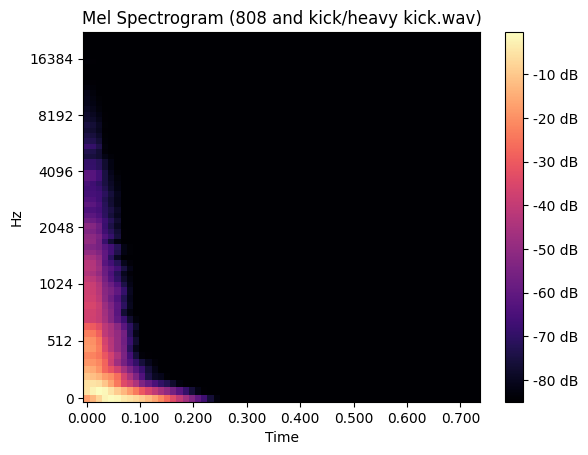

In [275]:
idx = 0
librosa.display.specshow(X_images[idx][0, :, :, 1].squeeze(), sr=df['sample_rate'][idx], x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectrogram ({df['file_path'][idx]})")
plt.show()

In [295]:
X_train_images, X_test_images, X_train_features, X_test_features, X_train_spectrums, X_test_spectrums, X_train_energies, X_test_energies, y_train, y_test = train_test_split(X_images, X_features, X_spectrums, X_energies, y, test_size=0.2, random_state=42)

X_train_images = tf.ragged.constant(X_train_images, dtype=tf.float32, ragged_rank=1)
X_test_images = tf.ragged.constant(X_test_images, dtype=tf.float32, ragged_rank=1)
#X_train_gru = tf.ragged.constant(X_train_gru, dtype=tf.float32, ragged_rank=1)
#X_test_gru = tf.ragged.constant(X_test_gru, dtype=tf.float32, ragged_rank=1)
X_train_spectrums = tf.ragged.constant(X_train_spectrums, dtype=tf.float32, ragged_rank=1)
X_test_spectrums = tf.ragged.constant(X_test_spectrums, dtype=tf.float32, ragged_rank=1)
X_train_energies = tf.ragged.constant(X_train_energies, dtype=tf.float32, ragged_rank=1)
X_test_energies = tf.ragged.constant(X_test_energies, dtype=tf.float32, ragged_rank=1)

X_train_energies = X_train_energies.with_flat_values(
    tf.expand_dims(tf.cast(X_train_energies.flat_values, tf.float32), axis=-1)
)
X_test_energies = X_test_energies.with_flat_values(
    tf.expand_dims(tf.cast(X_test_energies.flat_values, tf.float32), axis=-1)
)

X_train_spectrums = X_train_spectrums.with_flat_values(
    tf.expand_dims(tf.cast(X_train_spectrums.flat_values, tf.float32), axis=-1)
)
X_test_spectrums = X_test_spectrums.with_flat_values(
    tf.expand_dims(tf.cast(X_test_spectrums.flat_values, tf.float32), axis=-1)
)

#X_train_spectrums = tf.ragged.map_flat_values(lambda x: tf.expand_dims(x, axis=-1), X_train_spectrums)
#X_test_spectrums = tf.ragged.map_flat_values(lambda x: tf.expand_dims(x, axis=-1), X_test_spectrums)


y_train_pd = y_train[predictor_labels].to_numpy()
y_test_pd = y_test[predictor_labels].to_numpy()

In [296]:
print(X_train_images.shape)
print(X_train_energies.shape)
print(X_train_spectrums.shape)
#print(len(X_test_images))

(3128, None, 64, 64, 2)
(3128, None, 3, 87, 1)
(3128, None, 5, 44, 1)


In [49]:
print(len(y_train))
print(len(y_test))

#1585
#397

3128
783


In [50]:
y_train_pd[:5]

array([[0, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 0, 1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 1, 0, 0, 1]])

In [51]:
print(type(y_train))
print(np.isnan(y_test[predictor_labels]).any())

<class 'pandas.core.frame.DataFrame'>
Reverse       False
Forward       False
One_Shot      False
Loop          False
Drum          False
Percussion    False
Kick          False
Clap          False
Hi Hat        False
dtype: bool


In [52]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [281]:
print(X_train_energies[0][0].shape[0])

3


##creating model

##predict

In [56]:
print(X_train_energies[0][0].shape[0])

3


In [298]:
print(X_train_spectrums[0][0].shape[0],X_train_spectrums[0][0].shape[1],X_train_spectrums[0][0].shape[2])
print(X_train_spectrums[0].shape) 

5 44 1
(5, 5, 44, 1)


In [ ]:
dropout_val_1 = 0.35
dropout_val_2 = 0.5

# Define CNN model
tf.keras.backend.clear_session()

images_cnn_branch = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(X_train_images[0][0].shape[0],X_train_images[0][0].shape[1],X_train_images[0][0].shape[2])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    #Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    #BatchNormalization(),
    #MaxPooling2D((2, 2)),
    #Dropout(0.25),

    tf.keras.layers.Flatten()
])

energies_cnn_branch = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(X_train_energies[0][0].shape[0], X_train_energies[0][0].shape[1], X_train_energies[0][0].shape[2])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((1, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((1, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Flatten()
])

# branch for features (1 data point per feature)
features_branch = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(len(features_labels),)),
    tf.keras.layers.Dropout(dropout_val_1)
])

# branch for gru (array data)
'''gru_branch = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(None, 176))),
    tf.keras.layers.Dropout(dropout_val_1)
])'''


spectrums_cnn_branch = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(X_train_spectrums[0][0].shape[0],X_train_spectrums[0][0].shape[1],X_train_spectrums[0][0].shape[2])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((1, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((1, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Flatten()
])

# Inputs
input_images_cnn = tf.keras.layers.Input(shape=(None, X_train_images[0][0].shape[0],X_train_images[0][0].shape[1],X_train_images[0][0].shape[2]), ragged=True, dtype=tf.float32, name="images_input" )
input_features = tf.keras.layers.Input(shape=(len(features_labels),), ragged=True, dtype=tf.float32, name='features_input' )
#input_gru = tf.keras.Input(shape=(None, 176), ragged=True, name='gru_input')
input_spectrums_cnn = tf.keras.Input(shape=(None, X_train_spectrums[0][0].shape[0],X_train_spectrums[0][0].shape[1],X_train_spectrums[0][0].shape[2]), ragged=True, dtype=tf.float32, name='spectrums_input')
input_energies_cnn = tf.keras.layers.Input(shape=(None, X_train_energies[0][0].shape[0], X_train_energies[0][0].shape[1], X_train_energies[0][0].shape[2]), ragged=True, name='energies_input')

# images CNN + GRU path
images_time_dist = tf.keras.layers.TimeDistributed(images_cnn_branch, name='images_cnn_time_dist')(input_images_cnn)
images_cnn_gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', return_sequences=True, recurrent_activation='sigmoid', recurrent_dropout=dropout_val_1))(images_time_dist)
images_cnn_gru_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=dropout_val_1))(images_cnn_gru_1)
# add dropout layer(s)

# energies CNN + GRU path
energies_time_dist = tf.keras.layers.TimeDistributed(energies_cnn_branch, name='energies_cnn_time_dist')(input_energies_cnn)
energies_cnn_gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=dropout_val_1))(energies_time_dist)
energies_cnn_gru_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=dropout_val_1))(energies_cnn_gru_1)
# add dropout layer(s)

# feature path
features_out = features_branch(input_features)

# gru path
#gru_out = gru_branch(input_gru)

# spectrums CNN + GRU path
spectrums_time_dist = tf.keras.layers.TimeDistributed(spectrums_cnn_branch, name='spectrums_cnn_time_dist')(input_spectrums_cnn)
spectrums_cnn_gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=dropout_val_1))(spectrums_time_dist)
spectrums_cnn_gru_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=dropout_val_1))(spectrums_cnn_gru_1)

# Merging branches
merged_temporal_1 = tf.keras.layers.Concatenate()([images_cnn_gru_out, spectrums_cnn_gru_out])
merged_temporal_2 = tf.keras.layers.Concatenate()([merged_temporal_1, energies_cnn_gru_out])
merged = tf.keras.layers.Concatenate()([merged_temporal_2, features_out])

# Final output
#x = Dense(256, activation=tf.keras.layers.LeakyReLU(negative_slope=0.01))(merged)
#x = Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(merged)
x = tf.keras.layers.Dropout(0.5)(x)
final_output = tf.keras.layers.Dense(y_train[predictor_labels].shape[1], activation="sigmoid")(x)  # Output layer'''

model = tf.keras.Model(inputs=[input_images_cnn, input_features, input_spectrums_cnn, input_energies_cnn], outputs=final_output)

# Compile model
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00064)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[AUC(name='auc', multi_label=True), 'binary_accuracy'])

In [301]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 images_input (InputLayer)   [(None, None, 64, 64, 2)]    0         []                            
                                                                                                  
 spectrums_input (InputLaye  [(None, None, 5, 44, 1)]     0         []                            
 r)                                                                                               
                                                                                                  
 images_cnn_time_dist (Time  (None, None, 4608)           93856     ['images_input[0][0]']        
 Distributed)                                                                                     
                                                                                              

In [302]:
print((X_train_images.shape)) # idx 4 has 5 windows
print((X_train_features.shape))
print((X_train_spectrums.shape))
print((y_train_pd.shape))
print(X_test_images.shape)

(3128, None, 64, 64, 2)
(3128, 12)
(3128, None, 5, 44, 1)
(3128, 9)
(783, None, 64, 64, 2)


In [69]:


def create_stratified_batch(X_train_images, X_train_features, X_train_gru, X_train_energies, y_train, batch_size=32, seed=42):
    np.random.seed(seed)
    
    # Separate data into forward and reverse based on labels
    forward_indices = np.where((y_train['Reverse'] == 0) & (y_train['Forward'] == 1))[0]
    reverse_indices = np.where((y_train['Reverse'] == 1) & (y_train['Forward'] == 0))[0]
    forward_and_reverse_indices = np.where((y_train['Reverse'] == 1) & (y_train['Forward'] == 1))[0]
    
    # Shuffle indices for random sampling
    
    
    while True:
        np.random.shuffle(forward_indices)
        np.random.shuffle(reverse_indices)
        np.random.shuffle(forward_and_reverse_indices)

        split = batch_size // 3

        f_idx = forward_indices[:split]
        r_idx = forward_indices[:split]
        f_r_idx = forward_indices[:split]

        batch_idx = np.concatenate([f_idx, r_idx, f_r_idx])
        np.random.shuffle(batch_idx)

        batch_X = {
            'images_input': X_train_images[batch_idx],
            'features_input': X_train_features[batch_idx],
            'gru_input': X_train_gru[batch_idx],
            'energies_input': X_train_energies[batch_idx],
        }

        batch_y = y_train.iloc[batch_idx] if isinstance(y_train, pd.DataFrame) else y_train[batch_idx]
    
        yield batch_X, batch_y

In [80]:
X_train_images[5,0,0]

<tf.Tensor: shape=(64, 2), dtype=float32, numpy=
array([[-5.82978249e+01, -9.61278915e+00],
       [-6.13805199e+01, -6.45610762e+00],
       [-6.98555984e+01, -3.06351423e+00],
       [-8.79429245e+01, -1.15490294e+00],
       [-9.82585144e+01, -3.63446623e-01],
       [-1.06231201e+02, -2.55920235e-02],
       [-1.12592216e+02, -8.81503001e-02],
       [-1.17819405e+02, -6.03112876e-01],
       [-1.22593422e+02, -1.26022089e+00],
       [-1.26850975e+02, -2.04649377e+00],
       [-1.28645035e+02, -3.01257682e+00],
       [-1.29966110e+02, -4.11294174e+00],
       [-1.30939545e+02, -5.38971663e+00],
       [-1.31784882e+02, -7.19498348e+00],
       [-1.32360779e+02, -8.24282360e+00],
       [-1.32957321e+02, -8.83575249e+00],
       [-1.34051529e+02, -9.08377075e+00],
       [-1.34396561e+02, -1.01045675e+01],
       [-1.34696426e+02, -1.10752211e+01],
       [-1.35371689e+02, -1.14513826e+01],
       [-1.35566605e+02, -1.18783245e+01],
       [-1.35644180e+02, -1.23475962e+01],
     

In [303]:
# Train model
# Make sure X_train is a tuple: (cnn_input, dense_input)
# generator = create_stratified_batch(X_train_images, X_train_features, X_train_gru, X_train_energies)

# Save model at its best val_binary_accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'removed_gru_best_model.h5', 
    monitor='val_binary_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

# Optional: Early stopping
"""early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)"""

%time history = model.fit(x={'images_input': X_train_images, 'features_input': X_train_features, 'spectrums_input': X_train_spectrums, 'energies_input': X_train_energies}, y=y_train_pd, epochs=35, batch_size=32, validation_data=({'images_input': X_test_images, 'features_input': X_test_features, 'spectrums_input': X_test_spectrums, 'energies_input': X_test_energies}, y_test_pd), verbose=1, callbacks=[checkpoint])
#%time history = model.fit(x=generator, steps_per_epoch=len(y_train) //32, epochs=20, validation_data=({'images_input': X_test_images, 'features_input': X_test_features, 'gru_input': X_test_gru, 'energies_input': X_test_energies}, y_test_pd), verbose=1)
#model.fit(generator)

# model.fit(x=(X_train_images, X_train_features), y=y_train, epochs=250, batch_size=20, validation_data=((X_test_images, X_test_features), y_test))

Epoch 1/35
98/98 [==============================] - ETA: 0s - loss: 98.9100 - auc: 0.6052 - binary_accuracy: 0.7043
Epoch 1: val_binary_accuracy improved from -inf to 0.79750, saving model to removed_gru_best_model.h5
98/98 [==============================] - 40s 260ms/step - loss: 98.9100 - auc: 0.6052 - binary_accuracy: 0.7043 - val_loss: 7.0127 - val_auc: 0.7594 - val_binary_accuracy: 0.7975
Epoch 2/35


/Users/cheoso/venvs/py31112/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 13.4195 - auc: 0.6390 - binary_accuracy: 0.6781
Epoch 2: val_binary_accuracy improved from 0.79750 to 0.81765, saving model to removed_gru_best_model.h5
98/98 [==============================] - 32s 326ms/step - loss: 13.4195 - auc: 0.6390 - binary_accuracy: 0.6781 - val_loss: 0.9860 - val_auc: 0.7599 - val_binary_accuracy: 0.8177
Epoch 3/35
98/98 [==============================] - ETA: 0s - loss: 5.1499 - auc: 0.6207 - binary_accuracy: 0.6804
Epoch 3: val_binary_accuracy improved from 0.81765 to 0.82688, saving model to removed_gru_best_model.h5
98/98 [==============================] - 34s 343ms/step - loss: 5.1499 - auc: 0.6207 - binary_accuracy: 0.6804 - val_loss: 0.6366 - val_auc: 0.7388 - val_binary_accuracy: 0.8269
Epoch 4/35
98/98 [==============================] - ETA: 0s - loss: 3.7508 - auc: 0.6248 - binary_accuracy: 0.7045
Epoch 4: val_binary_accuracy did not improve from 0.82688
98/98 [==============================] -

##analyze

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Predict
model.load_weights('another_best_model.h5')
y_pred = (model.predict([X_test_images, X_test_features, X_test_spectrums, X_test_energies]) > 0.55).astype(int)  # threshold sigmoid output

labs = ['id', 'file_path', 'file_name']
labs += predictor_labels

y_meta = y_test[['id', 'file_path', 'file_name']]

pred = pd.DataFrame(y_pred, columns=predictor_labels)

predss = pd.concat([y_meta.reset_index(drop=True), pred.reset_index(drop=True)], axis=1)

# predss = pd.DataFrame(y_pred, columns=predictor_labels)


print(len(predictor_labels))
print(len(predss.iloc[0]))

# Multi-label F1 score
print(f"F1 Score: {f1_score(y_test[predictor_labels], predss[predictor_labels], average='weighted')}")
print(classification_report(y_test[predictor_labels], y_pred, target_names=predictor_labels))

25/25 [==============================] - 3s 50ms/step
9
12
F1 Score: 0.8960872011205618
              precision    recall  f1-score   support

     Reverse       0.89      0.70      0.78       364
     Forward       0.79      0.85      0.82       420
    One_Shot       0.99      1.00      1.00       776
        Loop       0.00      0.00      0.00         7
        Drum       0.96      0.96      0.96       241
  Percussion       0.99      0.98      0.98       542
        Kick       0.97      0.96      0.97       241
        Clap       1.00      0.44      0.61       249
      Hi Hat       0.92      0.83      0.87       293

   micro avg       0.94      0.87      0.90      3133
   macro avg       0.83      0.75      0.78      3133
weighted avg       0.94      0.87      0.90      3133
 samples avg       0.94      0.87      0.90      3133



/Users/cheoso/venvs/py31112/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [105]:
labs = ['id', 'file_path', 'file_name']
labs += predictor_labels
# add back the ids to preds
with pd.ExcelWriter("another_with_reverse_output.xlsx") as writer:
    predss.to_excel(writer, sheet_name="predicted values", index=False)
    y_test[labs].to_excel(writer, sheet_name="actual values", index=False)

In [ ]:
model.save_weights("kick_hihat_clap_with_reverse_weights.h5")

In [ ]:
#! ls drive/MyDrive/Colab\ Notebooks/audio\ classification

 archives				    classifier_updates.ipynb
'audio_metadata - filtered.csv'		    filtered_audio_data.h5
'audio_metadata - filtered(mixed).csv'	   'filtered_audio_data(no claps).h5'
'audio_metadata - filtered(no claps).csv'   model_weights.h5
 audio_metadata.gsheet			    output.xlsx
 classifier.ipynb			    testing


In [ ]:
#raw_preds = model.predict(X_test)
#threshold = 0.5

# Apply threshold to the predictions
#binary_preds = (raw_preds > threshold).astype(int)

# Print the first 3 predictions as binary labels
# print(len(y_pred))
#predss = pd.DataFrame(y_pred, columns=predictor_labels)
#print(binary_preds[:3])
predss.head(50)

,id,file_path,file_name,Forward,One_Shot,Loop,Drum,Percussion,Kick,Clap,Hi Hat
0,7553,gnx kendrick lamar drum kit - chrome kits/hiha...,hi hat (26)(1).wav,1,1,0,0,1,0,0,1
1,7600,gnx kendrick lamar drum kit - chrome kits/hiha...,hi hat (38)(1).wav,1,1,0,0,1,0,0,1
2,11076,vengeance essential club sounds-3/vec3 claps/v...,VEC3 Claps 056.wav,1,1,0,0,1,0,1,0
3,9593,trisamples - 100 kick drums vol 1/kick 012 cle...,Kick 012 Cleaned Noise.wav,1,1,0,1,0,1,0,0
4,16237,rehab drum kit - chrome kits/clap/clap (2).wav,clap (2).wav,1,1,0,0,1,0,0,0
5,12738,drill_samples/hihat.wav,hihat.wav,1,1,0,0,1,0,0,1
6,3289,808 samples/kick/kick (6).wav,kick (6).wav,1,1,0,1,0,1,0,0
7,11782,vengeance essential club sounds-3/vec3 bassdru...,VEC3 Bassdrums Clubby 022.wav,1,1,0,1,0,1,0,0
8,3392,808 samples/hi hat/hi hat (5).wav,hi hat (5).WAV,1,1,0,0,1,0,0,1
9,4864,roqstar - 10 hip hop claps/04_snappy_long_clap...,04_Snappy_Long_Clap.wav,1,1,0,0,1,0,0,0


In [ ]:
print(len(y_test))

149


In [ ]:
labs = ['id', 'file_path', 'file_name']
labs += predictor_labels
y_test[labs].head(7)

,id,file_path,file_name,Reverse,Forward,Drum,Percussion,Kick,808,Clap,Hi Hat,Snare
121,6640,bt sample packs/alex calver sample pack/kix/re...,Reverse Kickverb 4.wav,1,0,1,0,1,0,0,0,0
197,3641,dre & drumma boy/cool & dre/cl-hh1(l.wav,CL-HH1(L.WAV,0,1,0,1,0,0,0,1,0
348,3194,p46 xtreme beat kit/perc/hip-hop x-treme hi's ...,hip-hop X-treme HI's and Opens 5.wav,0,1,0,1,0,0,0,1,0
594,11957,vengeance essential club sounds-3/vec3 bassdru...,VEC3 Bassdrums Clubhouse 16.wav,0,1,1,0,1,0,0,0,0
407,9658,trisamples - 100 kick drums vol 1/kick 011 the...,Kick 011 The Spoon.wav,0,1,1,0,1,0,0,0,0
606,11955,vengeance essential club sounds-3/vec3 bassdru...,VEC3 Bassdrums Clubhouse 28.wav,0,1,1,0,1,0,0,0,0
76,3074,bbe_drumkits__/3 - hi hats/h-bbehat (2).wav.wav,H-BBEHAT (2).WAV.wav,0,1,0,1,0,0,0,1,0


In [ ]:
print(labs)

['id', 'file_path', 'file_name', 'Reverse', 'Forward', 'Drum', 'Percussion', 'Kick', '808', 'Clap', 'Hi Hat', 'Snare']


In [ ]:
real = pd.DataFrame(y_test, columns=predictor_labels)
real.reset_index(drop=True, inplace=True)
real.head(50)

,Reverse,Forward,Drum,Percussion,Kick,808,Clap,Hi Hat,Snare
0,0,1,1,0,0,0,0,0,1
1,0,1,1,0,1,0,0,0,0
2,0,1,1,0,0,0,0,0,1
3,0,1,1,0,0,0,0,0,1
4,0,1,1,0,1,0,0,0,0
5,0,1,1,0,0,0,0,0,1
6,0,1,1,0,0,1,0,0,0
7,0,1,0,1,0,0,0,1,0
8,0,1,1,0,0,0,0,0,1
9,0,1,0,1,0,0,0,1,0


In [ ]:
real[:50].sum()

,0
Reverse,4
Forward,46
Drum,15
Percussion,22
Effect,14
Vocal,0
Instrument,0
Kick,6
808,3
Clap,3


In [ ]:
predss[:50].sum()

,0
Reverse,0
Forward,50
Drum,47
Percussion,49
Effect,3
Vocal,0
Instrument,0
Kick,0
808,0
Clap,1


In [ ]:
print(y_pred[:10])

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]]


In [ ]:
print(np.array(real)[:10])

[[0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]]


In [ ]:
sample_input = X_test[0:1]  # Get a single sample
raw_pred = model(sample_input, training=False)
print(raw_pred)

tf.Tensor(
[[0.26164034 0.8398956  0.50589526 0.5698991  0.41104266 0.30791476
  0.2140901  0.2865647  0.23991893 0.3328972  0.10641238 0.4109426
  0.35369867 0.35924247 0.47018078 0.18324445 0.16728689 0.2225426
  0.2446728  0.1656221  0.1804362  0.40649697 0.38008764 0.28376195
  0.29797283 0.1885386  0.32134646 0.34042698 0.23215853 0.30023673
  0.21956052 0.32137087 0.2953372  0.29958877 0.13974343 0.2111773
  0.27773172 0.20350832 0.23027214]], shape=(1, 39), dtype=float32)


In [ ]:
assert np.all(np.isfinite(X_train_images)), "X_train_images contains NaN or Inf!"
assert np.all(np.isfinite(X_test_images)), "X_test_images contains NaN or Inf!"
assert np.all(np.isfinite(X_train_features)), "X_train_features contains NaN or Inf!"
assert np.all(np.isfinite(X_test_features)), "X_test_features contains NaN or Inf!"
assert np.all(np.isfinite(y_train)), "y_train contains NaN or Inf!"
assert np.all(np.isfinite(y_test)), "y_test contains NaN or Inf!"

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
y_train.columns

Index(['id', 'file_path', 'file_name', 'Reverse', 'Forward', 'Drum',
       'Percussion', 'Effect', 'Vocal', 'Instrument', 'Kick', '808', 'Clap',
       'Ride', 'Hi Hat', 'Tom', 'Snare', 'Impact', 'Noise', 'Hit', 'Sweep',
       'Misc', 'Rim Shot', 'Clave', 'Crash', 'Ambient', 'Stab', 'Other',
       'Chord', 'Glitch', 'Shaker', 'Snap', 'Timpani', 'Congo', 'Vocal FX',
       'Triangle', 'China', 'Cowbell', 'Tambourine', 'Bell', 'Metalic Tap',
       'Vibraslap', 'sample_rate', 'waveform', 'time', 'is_long',
       'mfcc_resized', 'mel_resized', 'centroid', 'bandwidth',
       'onset_strength', 'zcr', 'centroid_mean', 'bandwidth_mean',
       'bandwidth_low_10', 'bandwidth_low', 'bandwidth_high_90',
       'bandwidth_high', 'bandwidth_range', 'onset_strength_max',
       'onset_strength_mean', 'zcr_mean'],
      dtype='object')

In [ ]:
y_train.isnull().sum()

,0
id,0
Reverse,0
Forward,0
Drum,0
Percussion,0
Kick,0
808,0
Clap,0
Hi Hat,0
Snare,0


In [ ]:
print(type(X_train_features))
print(X_train_features.dtype if isinstance(X_train_features, np.ndarray) else "Not a NumPy array")


<class 'numpy.ndarray'>
object
